# Extreme Events EDA

Goals: explore how extreme climate events affect GPP and how plants memorize extreme events and change response moving forward

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore, skew
from sklearn.cluster import KMeans

# Set paths
wd = '/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling/'
data = wd + 'data/datasets/'
hh_data = data + 'half_hourly/'
code = wd + 'code/src/'

In [2]:
site_meta = {}

### 0. Explore Site Data

In [3]:
# Load one site
site = os.listdir(hh_data)[1]
site_df = pd.read_csv(hh_data + site)
site_name = site.split('_')[-1][:-4]
print(f"Site: {site_name}")
site_meta['SITE_ID'] = site_name
site_df.head()

Site: CN-HaM


,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,-0.006405,0.9252,0.9123,0.8571,0.9113,0.5601,0.1609,0.0708,GRA,Polar


In [4]:
# Check nulls
nulls = site_df.isnull().sum().sort_values(ascending=False)/len(site_df)
nulls[:15]

SW_DIF             1.000000
b6                 0.437618
b5                 0.375236
NDVI               0.364839
EVI                0.364839
b7                 0.364839
b4                 0.364839
b3                 0.364839
b2                 0.364839
b1                 0.364839
NIRv               0.364839
PPFD_IN            0.047397
NETRAD             0.034519
NEE_VUT_REF_qa     0.026800
RECO_DT_CUT_REF    0.000000
dtype: float64

There are two routes to handling nulls for extreme events EDA:
1) Remove all rows with any NA in key feature columns before running analysis
2) Use what you can for each extreme GPP event, and know some info about that event might be missing (**WINNER**)
- This is best because the analysis runs at GPP level and then we check the surrounding predictor vars for extreme GPP events

#### 0.1 Load Site Data, Parse Dates

In [5]:
# Parse start time
def parse_timestamp(timestamp):
    date = timestamp[0:8]
    year = int(timestamp[0:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])
    hour = int(timestamp[8:10])
    mins = int(timestamp[10:12])
    return date, year, month, day, hour, mins

site_df[['DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINS']] = \
    site_df['TIMESTAMP_START'].astype(str).apply(parse_timestamp).apply(pd.Series)

#### 0.2 Create Precipitation Rolling Sum (7-day, 30-day)

In [6]:
site_df['P_ERA_ROLL7'] = site_df['P_ERA'].rolling(7, min_periods=1).sum()
site_df['P_ERA_ROLL30'] = site_df['P_ERA'].rolling(30, min_periods=1).sum()

#### 0.3 Create Season and 6-Hour Time-of-Day Groups

In [7]:
def define_season_tod(predictors, target='GPP_NT_VUT_REF', df=site_df):
    # Season indicator
    df['SEASON'] = ''
    df['SEASON_NUM'] = 1
    df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON'] = 'WINTER'
    df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON'] = 'SPRING'
    df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON'] = 'SUMMER'
    df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON'] = 'FALL'
    df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON_NUM'] = 1
    df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON_NUM'] = 2
    df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON_NUM'] = 3
    df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON_NUM'] = 4

    # 6-Hour TOD indicator
    df['TOD_GROUP'] = ''
    df.loc[df['HOUR'].isin(list(range(0, 6))), 'TOD_GROUP'] = '1'
    df.loc[df['HOUR'].isin(list(range(6, 12))), 'TOD_GROUP'] = '2'
    df.loc[df['HOUR'].isin(list(range(12, 18))), 'TOD_GROUP'] = '3'
    df.loc[df['HOUR'].isin(list(range(18, 24))), 'TOD_GROUP'] = '4'

    # Merge to define season-TOD groups
    df['SEASON_TOD'] = df['SEASON'] + '_' + df['TOD_GROUP']

    # Create GPP_extreme indicator to fill in later
    for feat in predictors:
        df['Z_' + feat] = 0
    df['Z_' + target] = 0
    df['EXT_IND_' + target] = 0

    return df


# Apply
predictors = ['TA_ERA', 'P_ERA', 'P_ERA_ROLL7', 'P_ERA_ROLL30', 'VPD_ERA',
            'SW_IN_ERA', 'LW_IN_ERA', 'PA_ERA', 'NDVI', 'EVI', 'NIRv'] # <--- CHECK IF OTHERS SHOULD BE INCLUDED
target = 'GPP_NT_VUT_REF'
site_df = define_season_tod(predictors, target, site_df)
site_df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,Z_P_ERA_ROLL30,Z_VPD_ERA,Z_SW_IN_ERA,Z_LW_IN_ERA,Z_PA_ERA,Z_NDVI,Z_EVI,Z_NIRv,Z_GPP_NT_VUT_REF,EXT_IND_GPP_NT_VUT_REF
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,0,0,0,0,0,0,0,0,0,0
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,0,0,0,0,0,0,0,0,0,0
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,0,0,0,0,0,0,0,0,0,0
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,0,0,0,0,0,0,0,0,0,0
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,0,0,0,0,0,0,0,0,0,0


### 1. GPP Extremes
Get Z-Values for each feature within SEASON_TOD group, identify extreme GPP events (z >= 3 std devs)

#### 1.1 Find GPP Extreme Events

In [8]:
def find_extremes(group_by, group, predictors, target, df=site_df):
    # Subset df to SEASON group
    subset = df[df[group_by]==group].copy()

    # Get z-scores for each record within ST group context
    for feat in predictors:
        arr = subset[feat]
        z = arr.copy()
        z[~np.isnan(arr)] = zscore(arr[~np.isnan(arr)]) # handle NANs
        df.loc[list(z.index), 'Z_' + feat] = z

    # Get GPP z-scores and identify extreme events
    arr = subset[target]
    z = arr.copy()
    z[~np.isnan(arr)] = zscore(arr[~np.isnan(arr)]) # handle NANs
    df.loc[list(z.index), 'Z_' + target] = z
    outlier_inds = z[np.abs(z) >= 3].index

    # Write GPP outliers to extreme_indicator var
    if len(outlier_inds) > 0:
        df.loc[list(outlier_inds), 'EXT_IND_' + target] = 1

    return df

# Apply
group_by = 'SEASON'
groups = site_df[group_by].unique()
for group in groups:
    site_df = find_extremes(group_by, group, predictors, target, site_df)
site_df.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,Z_P_ERA_ROLL30,Z_VPD_ERA,Z_SW_IN_ERA,Z_LW_IN_ERA,Z_PA_ERA,Z_NDVI,Z_EVI,Z_NIRv,Z_GPP_NT_VUT_REF,EXT_IND_GPP_NT_VUT_REF
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,-0.092432,-1.011177,-0.672088,2.503229,-1.089389,-1.447698,-1.877603,-1.645068,0.420225,0
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,0.176945,-1.000098,-0.672088,2.503229,-1.086221,-1.447698,-1.877603,-1.645068,-0.022128,0
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,0.446323,-0.989811,-0.672088,2.503229,-1.086221,-1.447698,-1.877603,-1.645068,-0.188048,0
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,0.446323,-0.979523,-0.672088,2.503229,-1.083054,-1.447698,-1.877603,-1.645068,0.808696,0
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,0.446323,-0.969236,-0.672088,2.168501,-1.083054,-1.447698,-1.877603,-1.645068,0.842227,0


In [9]:
## Get avg num of days with extreme events per year
# Z scores gaurantee that 1.5% of records will be extreme events. The question then becomes,
# .. how many of those records come on the same day, or are they spread out? And are the episodes consecutive or spread out?
event_counts = site_df.groupby('DATE')['EXT_IND_GPP_NT_VUT_REF'].sum()
event_days = len(event_counts[event_counts > 0])
record_years = len(site_df)/(2*24*365)
site_meta['EXT_EVENTS_PER_YEAR'] = event_days/record_years

#### 1.2 Determine Extreme "Episodes" vs. HH-level "Events"
Basically calling a sequence of extreme events one episode

<AxesSubplot: title={'center': 'Count of GPP Extreme Events per Date'}, xlabel='DATE', ylabel='COUNT_EVENTS'>

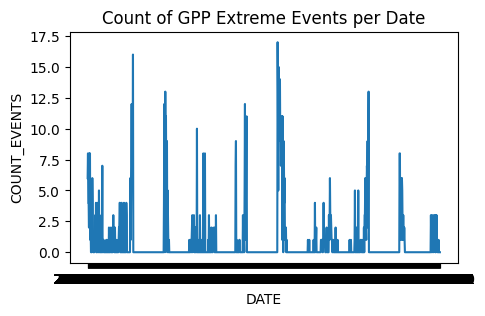

In [10]:
date_events = pd.DataFrame(site_df.groupby('DATE')['EXT_IND_GPP_NT_VUT_REF'].sum()).reset_index()
date_events.columns = ['DATE', 'COUNT_EVENTS']
site_meta['EXT_EVENTS_PER_DAY'] = date_events['COUNT_EVENTS'].mean()

plt.figure(figsize=(5, 3))
plt.title('Count of GPP Extreme Events per Date')
sns.lineplot(data=date_events, x = 'DATE', y='COUNT_EVENTS')

### 2.0 Cluster extreme events to see common types based on features

In [11]:
season_dummies = pd.get_dummies(site_df['SEASON'])
site_df = pd.concat([site_df, season_dummies], axis=1)

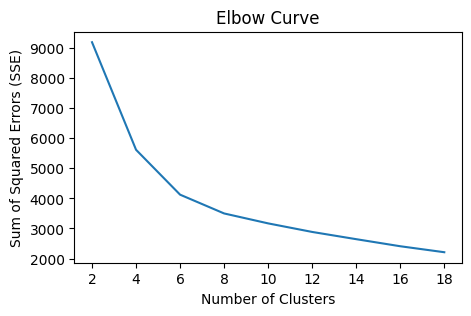

Optimal # of Clusters: 5


In [12]:
## FIRST, FIND OPTIMAL N_CLUSTERS
# subset to extreme GPP events
clust_feats = list(season_dummies.columns) + ['Z_' + i for i in predictors] + ['Z_GPP_NT_VUT_REF']
ext_gpp = site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, clust_feats].copy()
ext_gpp = ext_gpp.dropna(how='any')

def find_n_clusters(df, sse_reduction_thresh = 0.125):
    SSE = []
    for n_clusters in range(2, 20, 2):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        kmeans.fit(df)
        SSE.append(kmeans.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(5, 3))
    plt.plot(range(2, 20, 2), SSE)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.title("Elbow Curve")
    plt.show()

    # Determine num clusters based on SSE reduction threshold
    sse_decrease = 1- np.array(SSE)/np.roll(np.array(SSE), 1)
    sse_decrease[0] = 1.0
    n_clusters = np.where(sse_decrease < sse_reduction_thresh)[0][0] + 1
    n_clusters

    return n_clusters

n_clusters = find_n_clusters(ext_gpp)
site_meta['N_CLUSTERS'] = n_clusters
print(f"Optimal # of Clusters: {n_clusters}")

In [13]:
# cluster based on climate vars to find common themes
def k_means(df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(df)
    return kmeans.cluster_centers_, kmeans.labels_

# Apply
centers, labels = k_means(ext_gpp, n_clusters)
site_df.loc[ext_gpp.index, 'CLUSTER'] = labels

# investigate clusters
centers_df = pd.DataFrame(centers, columns=clust_feats)
centers_df.index = ["cluster_" + str(i) for i in range(n_clusters)]
centers_df.sort_values('Z_GPP_NT_VUT_REF', inplace=True)
centers_df.style.background_gradient()
centers_df.style.background_gradient(cmap='RdYlGn')

,FALL,SPRING,SUMMER,WINTER,Z_TA_ERA,Z_P_ERA,Z_P_ERA_ROLL7,Z_P_ERA_ROLL30,Z_VPD_ERA,Z_SW_IN_ERA,Z_LW_IN_ERA,Z_PA_ERA,Z_NDVI,Z_EVI,Z_NIRv,Z_GPP_NT_VUT_REF
cluster_1,0.000000,0.157895,0.000000,0.842105,-0.556585,-0.018878,0.553018,1.100058,-0.774327,-0.504626,0.124483,-0.355393,-1.395445,-1.668488,-1.526419,-4.686563
cluster_4,0.058252,0.330097,0.000000,0.611650,0.916269,-0.114266,-0.070545,-0.028940,1.002092,1.223551,0.116559,-0.231918,0.612429,0.627716,0.635737,-4.088710
cluster_2,0.951220,0.024390,0.000000,0.024390,1.086183,1.401767,2.307505,5.589240,-0.535719,0.387183,1.943463,0.318115,0.848846,0.995838,1.033760,3.459301
cluster_0,0.790164,0.206557,0.000000,0.003279,1.582602,-0.008306,-0.118961,-0.184067,1.331014,1.935064,0.898434,0.468337,0.954314,1.103362,1.130986,3.810364
cluster_3,0.000000,0.773810,0.000000,0.226190,0.834150,0.014314,0.109436,0.001031,0.054166,1.054370,0.855556,0.585143,-1.631537,-1.853130,-1.741169,3.886205


**FINDINGS**:
- Season: Negative events are more common in Winter, positive events in Fall. No events in Summer for this site
- Temperature: Positive GPP extremes generally associated with positive temperature
- Precipitation: Massive downpour event (cluster_6) led to negative GPP extreme. Otherwise not much of an effect
- Precip Rolling: A healthy 30-day rolling sum of precipitation, without an extreme single day seems to be positive for GPP
- NDVI, EVI, NIRv: Seem to be correlated. When low and also VPD, SW, LW, PA are low then negative GPP. But if the others become high, becomes positive

### 2.1 Determine Episodes from Events
Where episode is the set of consecutive days with extreme events

In [14]:
# Define an episode as the set of consecutive days that have a similar extreme event
episodes = date_events[date_events['COUNT_EVENTS'] > 0].copy()
episodes['DATE'] = episodes['DATE'].astype(int)
episodes['BEGIN_EP'] = (episodes['DATE'] - episodes['DATE'].shift(1) > 1).astype(int)
episodes.loc[0, 'BEGIN_EP'] = 1
episodes['EP_NUM'] = episodes['BEGIN_EP'].cumsum()
site_meta['NUM_EPISODES_PER_YR'] = episodes['BEGIN_EP'].sum()/record_years

# Merge back
episodes['DATE'] = episodes['DATE'].astype(str)
site_df = pd.merge(site_df, episodes[['DATE', 'EP_NUM']], how='left', on='DATE')

In [15]:
# What is average duration of episode?
episodes['DATE'] = episodes['DATE'].astype(int)
ep_time = pd.DataFrame(episodes.groupby('EP_NUM').agg({'DATE': ['min', 'max']}))
ep_time.columns = ['START', 'END']
ep_time['DURATION'] = ep_time['END'] - ep_time['START'] + 1

# Save summary metrics
site_meta['EP_AVG_DURATION'] = ep_time['DURATION'].mean()
site_meta['EP_MAX_DURATION'] = ep_time['DURATION'].max()

### 3.0 Investigate Findings

#### 2.1 Naive investigation to common trends in extreme events

**QUESTION 1**: Is the average extreme GPP event typically more positive or negative? \
**ANSWER**: More events are negative, and there are more highly negative events than highly positive ones

POSITIVE    616
NEGATIVE    275
Name: EXT_IND_GPP_DIRECTION, dtype: int64


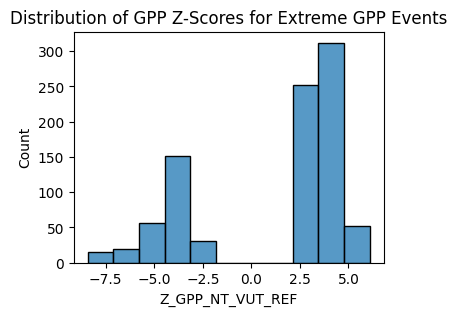

In [16]:
# Is average GPP extreme positive or negative?
site_df['EXT_IND_GPP_DIRECTION'] = np.nan
site_df.loc[(site_df['EXT_IND_GPP_NT_VUT_REF']==1) & (site_df['Z_GPP_NT_VUT_REF'] >= 3), 'EXT_IND_GPP_DIRECTION'] = 'POSITIVE'
site_df.loc[(site_df['EXT_IND_GPP_NT_VUT_REF']==1) & (site_df['Z_GPP_NT_VUT_REF'] <= -3), 'EXT_IND_GPP_DIRECTION'] = 'NEGATIVE'
print(site_df.loc[(site_df['EXT_IND_GPP_NT_VUT_REF']==1), 'EXT_IND_GPP_DIRECTION'].value_counts())

vals = site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, 'Z_GPP_NT_VUT_REF']
plt.figure(figsize=(4,3))
plt.title('Distribution of GPP Z-Scores for Extreme GPP Events')
sns.histplot(vals)
plt.show()

**QUESTION 2**: Which features are most correlated with extreme GPP event indicator? \
**ANSWER**: All are positive, and small. This isn't the perfect info to tell of what makes up a GPP extreme event

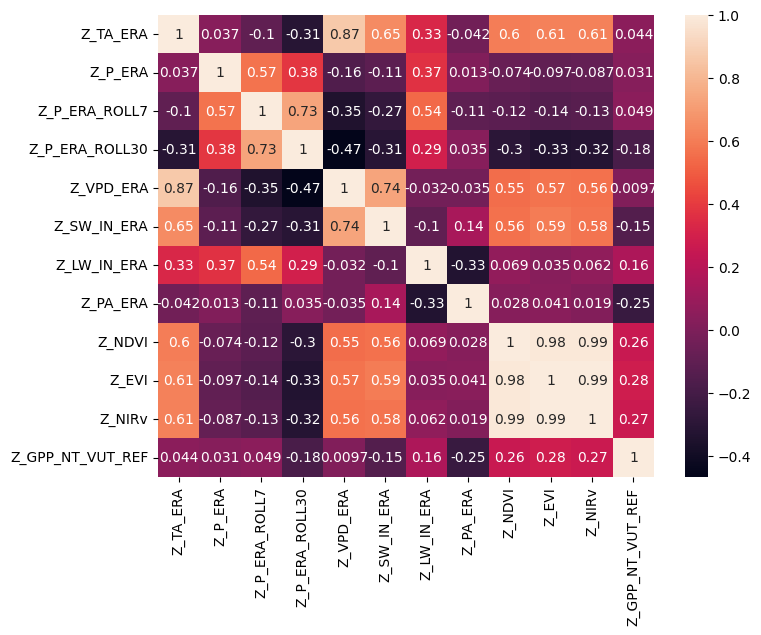

In [17]:
# Which feature is most correlated with negative GPP extreme events?
neg_events = site_df.loc[(site_df['EXT_IND_GPP_NT_VUT_REF']==1) & (site_df['EXT_IND_GPP_DIRECTION'] == 'NEGATIVE'), ].copy()
corr = neg_events[['Z_' + i for i in predictors] + ['Z_GPP_NT_VUT_REF']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True)
plt.show()

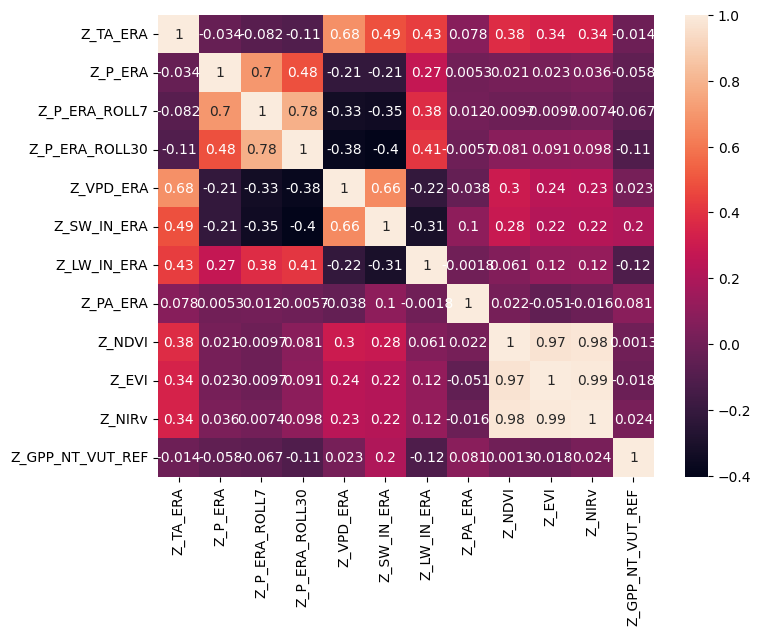

In [18]:
# Which feature is most correlated with positive GPP extreme events?
pos_events = site_df.loc[(site_df['EXT_IND_GPP_NT_VUT_REF']==1) & (site_df['EXT_IND_GPP_DIRECTION'] == 'POSITIVE'), ].copy()
corr = pos_events[['Z_' + i for i in predictors] + ['Z_GPP_NT_VUT_REF']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True)
plt.show()

**QUESTION 3**: What does the average GPP event look like in terms of predictor features? \

In [19]:
# Find average Z-score of predictor features for extreme GPP events
print("Average makeup of positive extreme events")
display(pos_events[['Z_' + i for i in predictors]].mean().sort_values(ascending=False))

print("Average makeup of negative extreme events")
display(neg_events[['Z_' + i for i in predictors]].mean().sort_values(ascending=False))

Average makeup of positive extreme events


Z_SW_IN_ERA       1.558227
Z_TA_ERA          1.327383
Z_LW_IN_ERA       0.926043
Z_VPD_ERA         0.801134
Z_NIRv            0.560643
Z_EVI             0.515562
Z_PA_ERA          0.487710
Z_NDVI            0.439115
Z_P_ERA_ROLL30    0.248169
Z_P_ERA           0.085712
Z_P_ERA_ROLL7     0.080946
dtype: float64

Average makeup of negative extreme events


Z_SW_IN_ERA       0.631637
Z_TA_ERA          0.462910
Z_VPD_ERA         0.379052
Z_P_ERA_ROLL30    0.323441
Z_LW_IN_ERA       0.195597
Z_P_ERA_ROLL7     0.180225
Z_PA_ERA          0.033527
Z_P_ERA           0.023365
Z_NDVI           -0.102876
Z_NIRv           -0.134531
Z_EVI            -0.190306
dtype: float64

### 4.0 Visualize 2 Similar Extreme Events

In [25]:
# Choose a cluster type:
clust_num = 4

# Find how many instances
c4_df = site_df.loc[site_df['CLUSTER']==clust_num, ].copy()
print(f"Total C4 events: {len(site_df.loc[site_df['CLUSTER']==clust_num, ])}")
print(f"Total C4 episodes: {len(c4_df['EP_NUM'].unique())}")

# Get two date ranges to compare GPP
display(c4_df.groupby('EP_NUM').agg({'TIMESTAMP_START':['min', 'max'], 'YEAR':['min'], 'MONTH':['min']}))
ep_range1 = [20020113, 20020129]
ep_range2 = [20020328, 20020404]

Total C4 events: 103
Total C4 episodes: 29


TIMESTAMP_START                YEAR MONTH
                   min           max   min   min
EP_NUM                                          
9.0       200202241430  200202241600  2002     2
10.0      200202271400  200202282030  2002     2
11.0      200203040500  200203040500  2002     3
17.0      200204011500  200204011500  2002     4
18.0      200204071430  200204071500  2002     4
19.0      200204121430  200204121430  2002     4
20.0      200204181500  200204221430  2002     4
21.0      200204271500  200204272000  2002     4
22.0      200204302030  200204302030  2002     4
35.0      200212261230  200212261230  2002    12
36.0      200212281630  200212281700  2002    12
37.0      200212301330  200212311500  2002    12
38.0      200301021100  200301021600  2003     1
39.0      200301051400  200301051400  2003     1
40.0      200301091100  200301091100  2003     1
41.0      200301111300  200301111400  2003     1
42.0      200301151430  200301151430  2003     1
43.0      200301211130  200301211500  2003     1
44.0      200301261230  200301261600  2003     1
45.0      200302051500  200302051500  2003     2
46.0      200302071330  200302071430  2003     2
48.0      200302151330  200302161400  2003     2
49.0      200302191130  200302231200  2003     2
52.0      200305011530  200305011530  2003     5
53.0      200305090530  200305100430  2003     5
56.0      200305312200  200305312200  2003     5
76.0      200404190930  200404201430  2004     4
78.0      200404302030  200404302030  2004     4
83.0      200409010630  200409152230  2004     9

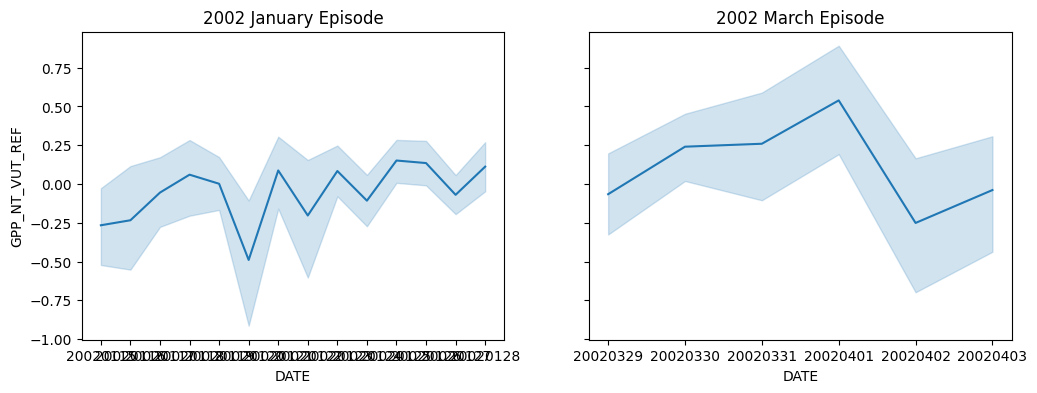

In [26]:
# Plot GPP for the two ranges
site_df['DATE_INT'] = site_df['DATE'].astype(int)
df_ep1 = site_df.loc[(site_df['DATE_INT']>ep_range1[0]) & (site_df['DATE_INT']<ep_range1[1]), ].copy()
df_ep2 = site_df.loc[(site_df['DATE_INT']>ep_range2[0]) & (site_df['DATE_INT']<ep_range2[1]), ].copy()

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.lineplot(y=df_ep1['GPP_NT_VUT_REF'], x=df_ep1['DATE'], ax=axs[0])
axs[0].set_title('2002 January Episode')
sns.lineplot(y=df_ep2['GPP_NT_VUT_REF'], x=df_ep2['DATE'], ax=axs[1])
axs[1].set_title('2002 March Episode')
plt.show()

**FINDING**: Seems that 2nd episode later in the year wasn't as bad for GPP. Could be because of warmer temp though